## Fronts
Ty Janoski

## Setup

In [1]:
# Import statements
from typing import List, Union

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pint
import scienceplots  # noqa: F401
import xarray as xr
from metpy.calc import gradient
from metpy.units import units
from scipy.ndimage import gaussian_filter, label

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def get_smoothed_ds(
    da: xr.DataArray, sigma: Union[float, int], axes: Union[str, List[str]] = None
):
    """
    Apply a Gaussian filter to specific dimensions of an xarray.DataArray and return
    a Dataset containing both the original and smoothed data.

    Parameters:
    - da (xr.DataArray): Input data array.
    - sigma (float or int): Standard deviation for the Gaussian kernel.
    - axes (str or List[str], optional): Dimensions to smooth over. Defaults to all dimensions.

    Returns:
    - xr.Dataset: A dataset containing the original and smoothed DataArrays.
    """
    # Type checking
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray.DataArray.")
    if not isinstance(sigma, (float, int)):
        raise TypeError("Sigma must be a float or an integer.")
    if axes is not None and not isinstance(axes, (str, list)):
        raise TypeError("Axes must be a string, a list of strings, or None.")

    # Convert a single axis string to a list
    if isinstance(axes, str):
        axes = [axes]

    # If no axes specified, apply to all dimensions
    if axes is None:
        axes = list(da.dims)

    # Convert dimension names to axis indices
    try:
        axis_indices = [da.get_axis_num(dim) for dim in axes]
    except ValueError as e:
        raise ValueError(f"Invalid axis name in {axes}: {e}")

    # Construct full sigma array where only selected axes are smoothed
    full_sigma = [sigma if i in axis_indices else 0 for i in range(da.ndim)]

    # Apply the Gaussian filter
    smoothed_data = gaussian_filter(da.values, sigma=full_sigma)

    # Create a new DataArray with the same metadata
    smoothed_da = xr.DataArray(
        smoothed_data,
        dims=da.dims,
        coords=da.coords,
        attrs={
            **da.attrs,
            "description": f"Gaussian smoothed (sigma={sigma}) over {axes}",
        },
    )

    # Combine original and smoothed data into a Dataset
    ds = xr.Dataset({"original": da, "smoothed": smoothed_da})

    return ds


def get_biggest_blob(array_in: pint.Quantity) -> pint.Quantity:
    "Label all blobs and only return the biggest one"
    # Identify blobs
    labeled_array, num_features = label(np.isfinite(array_in))  # type: ignore

    # Find largest blob
    largest_blob_size, largest_blob_label = 0, None
    for l_idx in range(1, num_features + 1):
        blob_size = np.sum(labeled_array == l_idx)
        if blob_size > largest_blob_size:
            largest_blob_size, largest_blob_label = blob_size, l_idx

    return np.where(labeled_array == largest_blob_label, array_in, np.nan)  # type: ignore


In [3]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


/tmp/ipykernel_3899633/1148083144.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3899633/1148083144.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3899633/1148083144.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3899633/1148083144.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


In [4]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


In [5]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


## Find fronts

In [6]:
# Get the wet and dry ensembles thetae fields
thetae_wet = (
    get_field(wofs_wet, "theta_e", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init)
    .stack(run=("init", "ne"))[0::12, :, :, :]
    .transpose("time", "run", "lat", "lon")
)
thetae_dry = (
    get_field(wofs_dry, "theta_e", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init)
    .stack(run=("init", "ne"))[0::12, :, :, :]
    .transpose("time", "run", "lat", "lon")
)
thetae_all = (
    get_field(wofs_all, "theta_e", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init)
    .stack(run=("init", "ne"))[0::12, :, :, :]
    .transpose("time", "run", "lat", "lon")
).mean(dim="run")

# Smooth
sigma = 9
thetae_wet = get_smoothed_ds(thetae_wet, sigma=sigma, axes=["lat", "lon"]).smoothed
thetae_dry = get_smoothed_ds(thetae_dry, sigma=sigma, axes=["lat", "lon"]).smoothed
thetae_all = (
    get_smoothed_ds(thetae_all, sigma=sigma, axes=["lat", "lon"]).smoothed
    * units.degree_Kelvin
)

# Make dx and dy
dx = 3 * 1000 * units.meter
dy = 3 * 1000 * units.meter

# Calculate gradients
grad_thetae_wet_y, grad_thetae_wet_x = gradient(
    thetae_wet, axes=(-2, -1), deltas=(dy, dx)
)
grad_thetae_dry_y, grad_thetae_dry_x = gradient(
    thetae_dry, axes=(-2, -1), deltas=(dy, dx)
)
grad_thetae_all_y, grad_thetae_all_x = gradient(
    thetae_all, axes=(-2, -1), deltas=(dy, dx)
)

# Calculate the gradient magnitude of thetae_wet
grad_thetae_wet_magnitude = np.sqrt(grad_thetae_wet_x**2 + grad_thetae_wet_y**2)
grad_thetae_dry_magnitude = np.sqrt(grad_thetae_dry_x**2 + grad_thetae_dry_y**2)
grad_thetae_all_magnitude = np.sqrt(grad_thetae_all_x**2 + grad_thetae_all_y**2)

# Normalize to find component orthogonal to gradient
grad_thetae_wet_unit_x = grad_thetae_wet_x / grad_thetae_wet_magnitude
grad_thetae_wet_unit_y = grad_thetae_wet_y / grad_thetae_wet_magnitude
grad_thetae_dry_unit_x = grad_thetae_dry_x / grad_thetae_dry_magnitude
grad_thetae_dry_unit_y = grad_thetae_dry_y / grad_thetae_dry_magnitude
grad_thetae_all_unit_x = grad_thetae_all_x / grad_thetae_all_magnitude
grad_thetae_all_unit_y = grad_thetae_all_y / grad_thetae_all_magnitude

# Calculate the gradient of the gradient magnitude
grad_mag_wet_y, grad_mag_wet_x = gradient(
    grad_thetae_wet_magnitude, axes=(-2, -1), deltas=(dy, dx)
)
grad_mag_dry_y, grad_mag_dry_x = gradient(
    grad_thetae_dry_magnitude, axes=(-2, -1), deltas=(dy, dx)
)
grad_mag_all_y, grad_mag_all_x = gradient(
    grad_thetae_all_magnitude, axes=(-2, -1), deltas=(dy, dx)
)

# Calculate the TFP as the negative dot product of the gradients
tfp_wet = -(
    grad_thetae_wet_unit_x * grad_mag_wet_x + grad_thetae_wet_unit_y * grad_mag_wet_y
)
tfp_dry = -(
    grad_thetae_dry_unit_x * grad_mag_dry_x + grad_thetae_dry_unit_y * grad_mag_dry_y
)
tfp_all = -(
    grad_thetae_all_unit_x * grad_mag_all_x + grad_thetae_all_unit_y * grad_mag_all_y
)

# Set a threshold based on apriori thetae gradients
threshold = (12 * units.kelvin / units.km).to("K/m") / 100

tfp_wet = np.where(grad_thetae_wet_magnitude > threshold, tfp_wet, np.nan)
tfp_dry = np.where(grad_thetae_dry_magnitude > threshold, tfp_dry, np.nan)
tfp_all = np.where(grad_thetae_all_magnitude > threshold, tfp_all, np.nan)

# Save out ensemble mean front locations
tfp_all_filtered = np.array(
    [get_biggest_blob(tfp_all[i, :, :]) for i in range(tfp_all.shape[0])] # type: ignore
)
np.save("data/front_locs_hourly_23_to_01.npy", tfp_all_filtered)


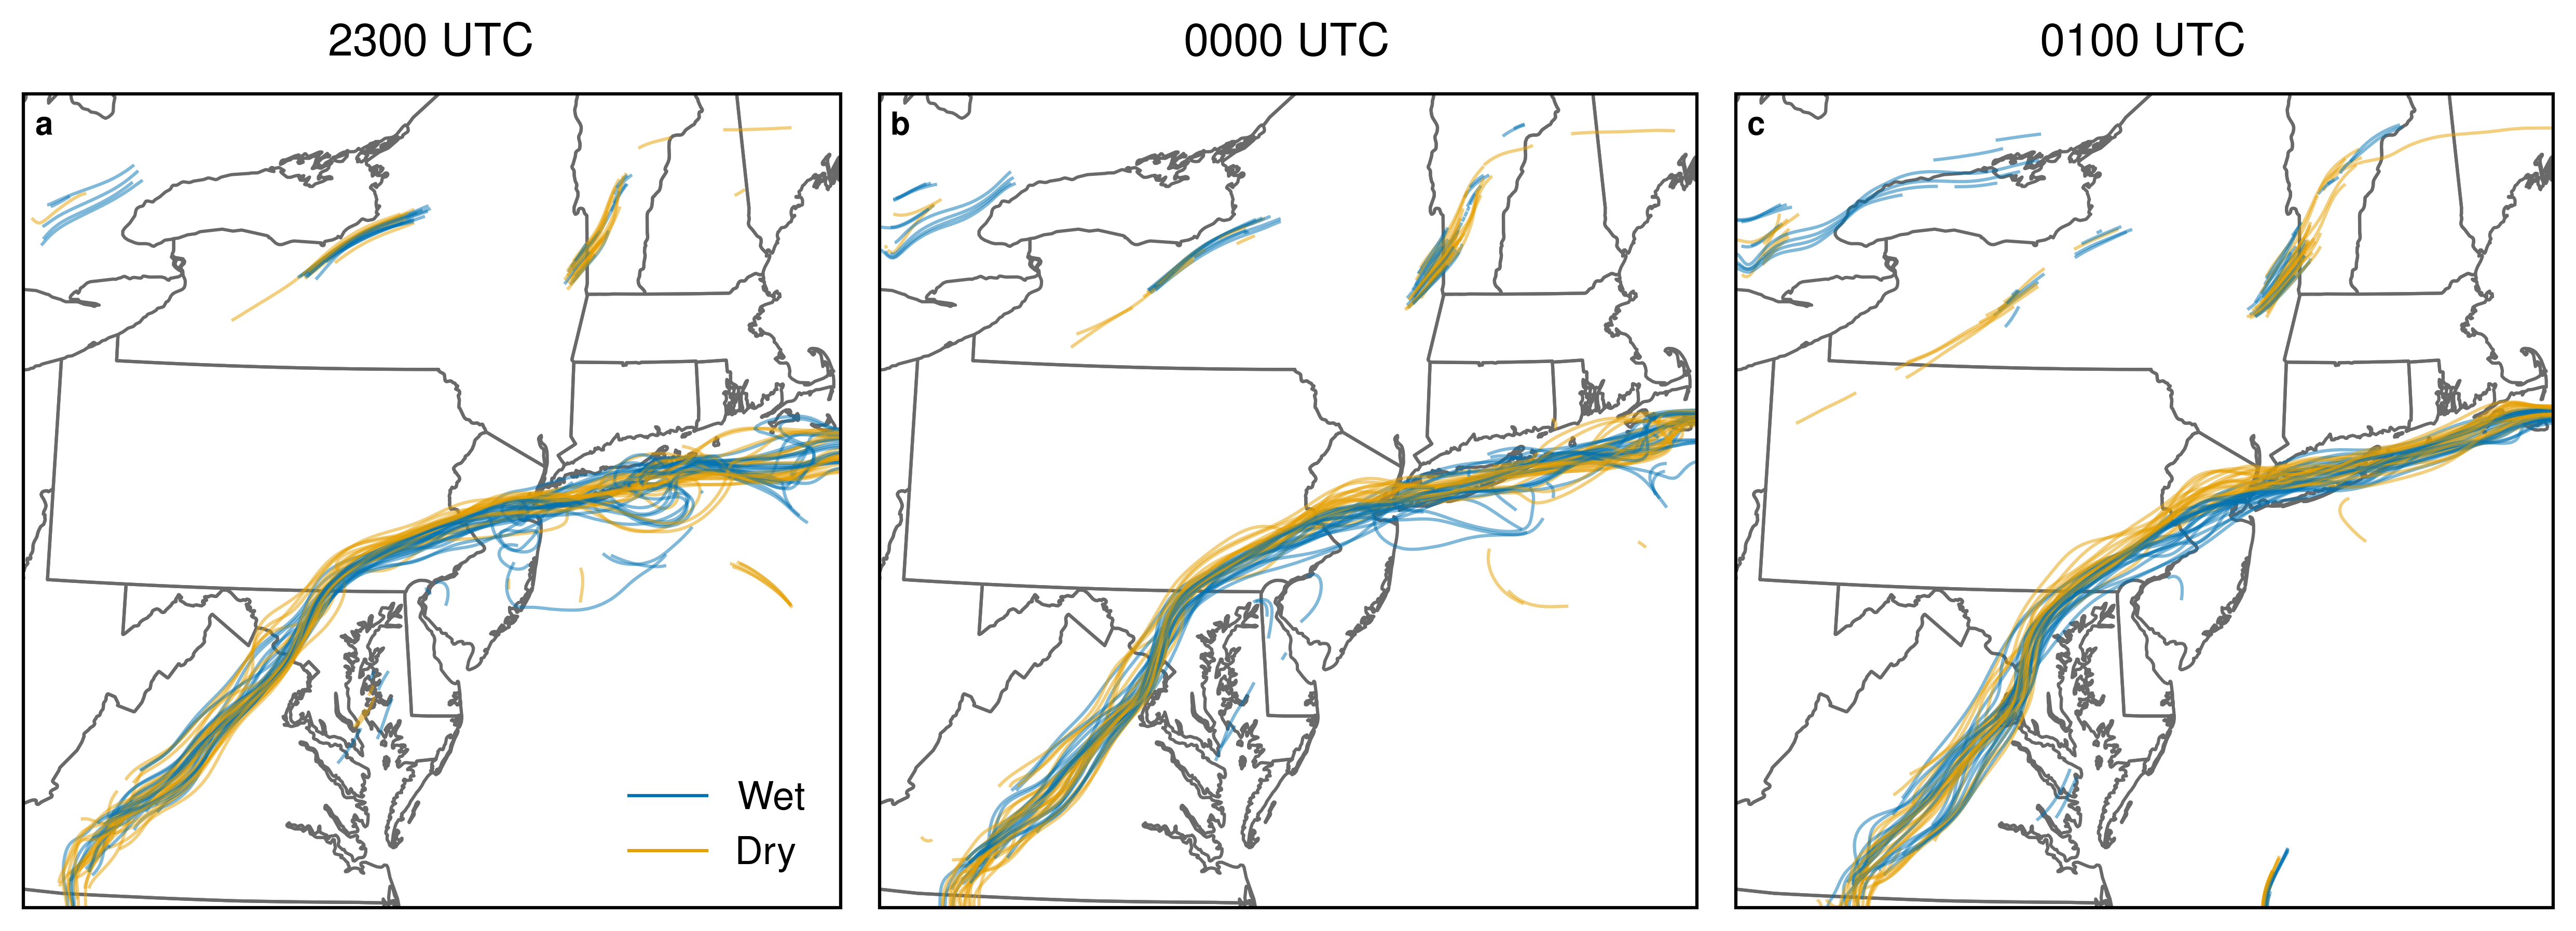

In [7]:
linewidths = 0.5

titles = ["2300 UTC", "0000 UTC", "0100 UTC"]
letters = ["a", "b", "c"]

# Create figure and subplots
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(5.5, 2),
    dpi=900,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes):
    # Iterate through each run and contour the zero line
    for r in range(tfp_wet.shape[1]):
        c_wet = ax.contour(
            lon,
            lat,
            tfp_wet[i, r],
            transform=ccrs.PlateCarree(),
            levels=[0],
            colors="#0072B2",
            alpha=0.5,
            linewidths=linewidths,
        )
        c_dry = ax.contour(
            lon,
            lat,
            tfp_dry[i, r],
            transform=ccrs.PlateCarree(),
            levels=[0],
            colors="#E69F00",
            alpha=0.5,
            linewidths=linewidths,
        )

    # Add state borders
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray")

    ax.set_extent(
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    ax.set_title(titles[i], fontsize=7)

    ax.text(
        0.015, 0.95, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )

wet_handle = mlines.Line2D([], [], color="#0072B2", label="Wet", linewidth=linewidths)
dry_handle = mlines.Line2D([], [], color="#E69F00", label="Dry", linewidth=linewidths)

axes[0].legend(handles=[wet_handle, dry_handle], loc="lower right", fontsize=6)

# Save fig
plt.savefig("figures/FigS7_unfilitered_fronts.pdf", bbox_inches="tight")

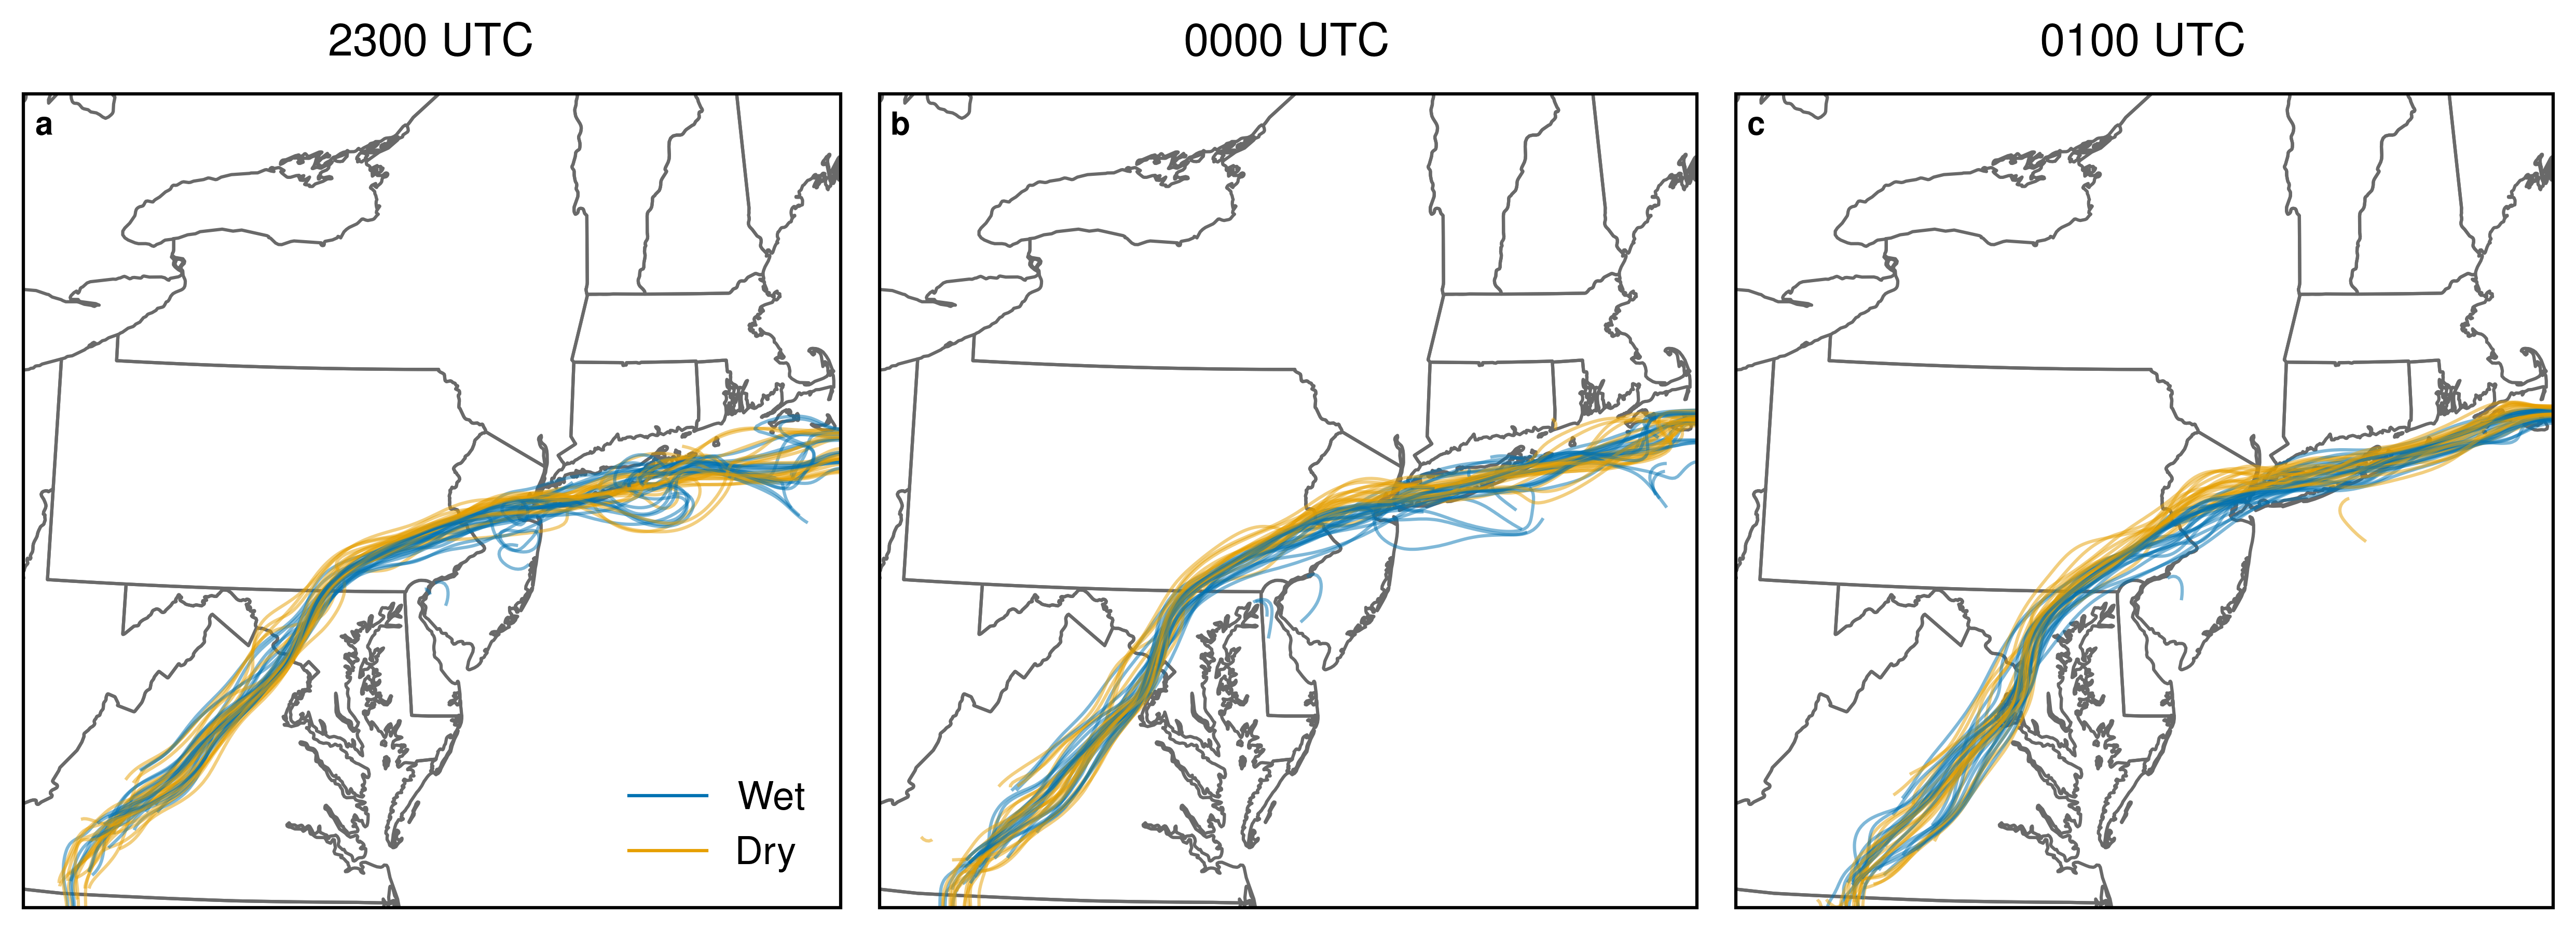

In [8]:
linewidths = 0.5

titles = ["2300 UTC", "0000 UTC", "0100 UTC"]
letters = ["a", "b", "c"]

# Create figure and subplots
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(5.5, 2),
    dpi=900,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes):
    # Iterate through each run and contour the zero line
    for r in range(tfp_wet.shape[1]):
        wet_to_plot = get_biggest_blob(tfp_wet[i, r])
        c_wet = ax.contour(
            lon,
            lat,
            wet_to_plot,
            transform=ccrs.PlateCarree(),
            levels=[0],
            colors="#0072B2",
            alpha=0.5,
            linewidths=linewidths,
        )
        dry_to_plot = get_biggest_blob(tfp_dry[i, r])
        c_dry = ax.contour(
            lon,
            lat,
            dry_to_plot,
            transform=ccrs.PlateCarree(),
            levels=[0],
            colors="#E69F00",
            alpha=0.5,
            linewidths=linewidths,
        )

    # Add state borders
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray")

    ax.set_extent(
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    ax.set_title(titles[i], fontsize=7)

    ax.text(
        0.015, 0.95, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )

wet_handle = mlines.Line2D([], [], color="#0072B2", label="Wet", linewidth=linewidths)
dry_handle = mlines.Line2D([], [], color="#E69F00", label="Dry", linewidth=linewidths)

axes[0].legend(handles=[wet_handle, dry_handle], loc="lower right", fontsize=6)

# Save fig
plt.savefig("figures/Fig13_fronts.pdf", bbox_inches="tight")
